# Category 5

Sequence (시계열) 데이터 다루기

For this task you will need to train a neural network
to predict sunspot activity using the Sunspots.csv
provided. 

Your neural network is expected to have an MAE
of at least 20, with top marks going to one with an MAE
of around 15. 

At the bottom is provided some testing
code should you want to check before uploading which measures
the MAE for you. 

Strongly recommend you test your model with
this to be able to see how it performs.



-------------------------------
**Sequence(시퀀스)**

Sunspots.csv를 사용하여 **태양 흑점 활동(sunspot)을 예측하는 인공신경망을 만듭니다.

MAE 오차 기준으로 최소 20이하로 예측할 것을 권장하며, 탑 랭킹에 들려면 MAE 15 근처에 도달해야합니다.

아래 주어진 샘플코드는 당신의 모델을 테스트 하는 용도로 활용할 수 있습니다.

# 1. Import

In [1]:
import csv
import tensorflow as tf
import numpy as np
import urllib

from tensorflow.keras.layers import Dense, LSTM, Lambda, Conv1D
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.losses import Huber

# 2. Dataset load

In [2]:
url = 'https://storage.googleapis.com/download.tensorflow.org/data/Sunspots.csv'
urllib.request.urlretrieve(url, 'sunspots.csv')

('sunspots.csv', <http.client.HTTPMessage at 0x7f83301c24d0>)

In [3]:
# 데이터 확인
with open('sunspots.csv') as csvfile:
  reader = csv.reader(csvfile, delimiter=',')
  next(reader) # header 제외
  i = 0
  for row in reader:
    print(row)
    i+=1
    if i > 5:
      break

['0', '1749-01-31', '96.7']
['1', '1749-02-28', '104.3']
['2', '1749-03-31', '116.7']
['3', '1749-04-30', '92.8']
['4', '1749-05-31', '141.7']
['5', '1749-06-30', '139.2']


`time_step`에는 index 값을, `sunspots`에는 sunspots의 정보를 넣어줌

In [4]:
sunspots = []
time_step = []

In [5]:
with open('sunspots.csv') as csvfile:
  reader = csv.reader(csvfile, delimiter=',')
  next(reader)
  for row in reader:
    sunspots.append(float(row[2]))
    time_step.append(int(row[0]))

In [6]:
sunspots[:5]

[96.7, 104.3, 116.7, 92.8, 141.7]

In [7]:
time_step[:5]

[0, 1, 2, 3, 4]

sunspots와 time_step을 `numpy array`로 변환

* 참고: 모델은 list 타입을 받아들이지 못하므로 numpy array 로 변환

In [8]:
series = np.array(sunspots)
time = np.array(time_step)

In [9]:
series.shape, time.shape

((3235,), (3235,))

* data 시각화

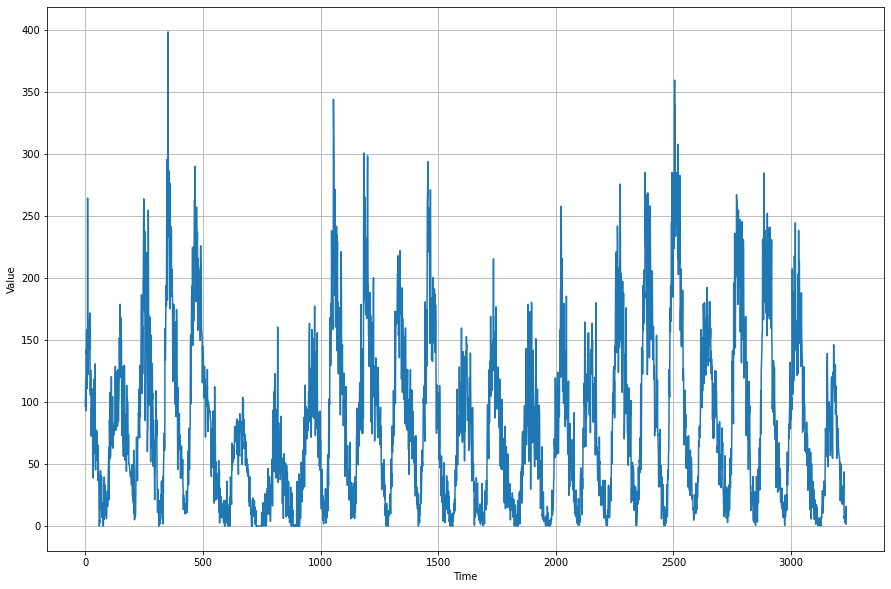

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 10))
plt.plot(time, series)
plt.xlabel('Time')
plt.ylabel("Value")
plt.grid('True')

# 3. preprocess

### 3-1. train, valid set 생성

3000 인덱스 기준 train, valid set 분할

In [11]:
split_time = 3000

In [12]:
time_train = time[:split_time]
time_valid = time[split_time:]

In [13]:
x_train = series[:split_time]
x_valid = series[split_time:]

### 3-2. Window Dataset Loader

In [14]:
# 윈도우 사이즈
window_size = 30
# 배치 사이즈
batch_size = 32
# 셔플 사이즈
shuffle_size = 1000

In [15]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  series = tf.expand_dims(series, axis=-1)
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
  ds = ds.flat_map(lambda w: w.batch(window_size + 1))
  ds = ds.shuffle(shuffle_buffer)
  ds = ds.map(lambda w: (w[:-1], w[1:]))
  return ds.batch(batch_size).prefetch(1)

https://teddylee777.github.io/tensorflow/dataset-batch-window

In [17]:
train_set = windowed_dataset(x_train,
                             window_size=window_size,
                             batch_size=batch_size,
                             shuffle_buffer=shuffle_size)

In [19]:
validation_set = windowed_dataset(x_valid,
                                 window_size = window_size,
                                 batch_size = batch_size,
                                 shuffle_buffer=shuffle_size)

# 4. 모델 정의 (Sequential)

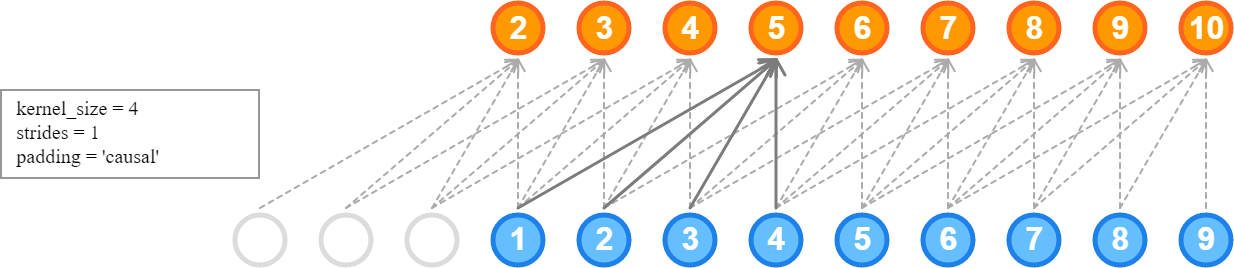

In [20]:
from IPython.display import Image

Image('https://i.stack.imgur.com/NmYZJ.png')

In [22]:
model = Sequential([
                    Conv1D(60, kernel_size =5,
                           padding='causal',
                           activation='relu',
                           input_shape=[None, 1]),
                    LSTM(60, return_sequences=True),
                    LSTM(60, return_sequences=True),
                    Dense(30, activation='relu'),
                    Dense(10, activation='relu'),
                    Dense(1),
                    Lambda(lambda x: x * 400)
])

In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, None, 60)          360       
_________________________________________________________________
lstm (LSTM)                  (None, None, 60)          29040     
_________________________________________________________________
lstm_1 (LSTM)                (None, None, 60)          29040     
_________________________________________________________________
dense (Dense)                (None, None, 30)          1830      
_________________________________________________________________
dense_1 (Dense)              (None, None, 10)          310       
_________________________________________________________________
dense_2 (Dense)              (None, None, 1)           11        
_________________________________________________________________
lambda (Lambda)              (None, None, 1)           0

# 5. Compile

**Optimizer**는 SGD(Stochastic Gradient Descent) 를 사용합니다.

* lr(learning_rate): 학습률입니다.
* momentum: 모멘텀 (가중치) 입니다.

In [25]:
optimizer = SGD(learning_rate=1e-5, momentum=0.9)

**Huber Loss**: MSE와 MAE를 절충한 후버 손실(Huber loss)

In [26]:
loss = Huber()

In [27]:
model.compile(optimizer=optimizer,
              loss=loss,
              metrics=["mae"])

# 6. ModelCheckpoint

In [28]:
checkpoint_path = 'my_checkpoint.ckpt'
checkpoint= ModelCheckpoint(filepath=checkpoint_path,
                            save_weights_only=True,
                            save_best_only=True,
                            monitor='val_mae',
                            verbose=1)

# 7. fit

In [29]:
epochs=100

In [30]:
history = model.fit(train_set,
                    validation_data=(validation_set),
                    epochs=epochs,
                    callbacks=[checkpoint])

Epoch 1/100
93/93 [==============================] - 36s 34ms/step - loss: 29.9215 - mae: 30.4163 - val_loss: 19.9073 - val_mae: 20.4034

Epoch 00001: val_mae improved from inf to 20.40341, saving model to my_checkpoint.ckpt
Epoch 2/100
93/93 [==============================] - 2s 22ms/step - loss: 21.2707 - mae: 21.7643 - val_loss: 15.7949 - val_mae: 16.2879

Epoch 00002: val_mae improved from 20.40341 to 16.28791, saving model to my_checkpoint.ckpt
Epoch 3/100
93/93 [==============================] - 2s 22ms/step - loss: 20.1152 - mae: 20.6081 - val_loss: 16.2537 - val_mae: 16.7459

Epoch 00003: val_mae did not improve from 16.28791
Epoch 4/100
93/93 [==============================] - 2s 22ms/step - loss: 19.0091 - mae: 19.5018 - val_loss: 14.8652 - val_mae: 15.3547

Epoch 00004: val_mae improved from 16.28791 to 15.35467, saving model to my_checkpoint.ckpt
Epoch 5/100
93/93 [==============================] - 2s 22ms/step - loss: 18.3459 - mae: 18.8381 - val_loss: 15.4488 - val_mae: 1

# 8. Load Weights

In [31]:
model.load_weights(checkpoint_path)

# 학습 오차에 대한 시각화

In [32]:
import matplotlib.pyplot as plt

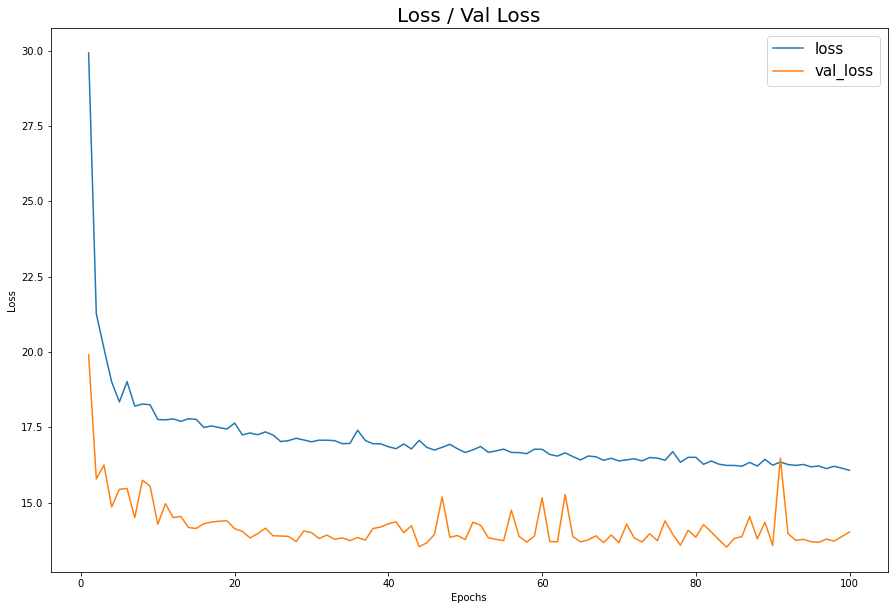

In [36]:
plt.figure(figsize=(15,10))
plt.plot(np.arange(1, epochs+1), history.history['loss'])
plt.plot(np.arange(1, epochs+1), history.history['val_loss'])
plt.title('Loss / Val Loss', fontsize=20)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['loss', 'val_loss'], fontsize=15)
plt.show()

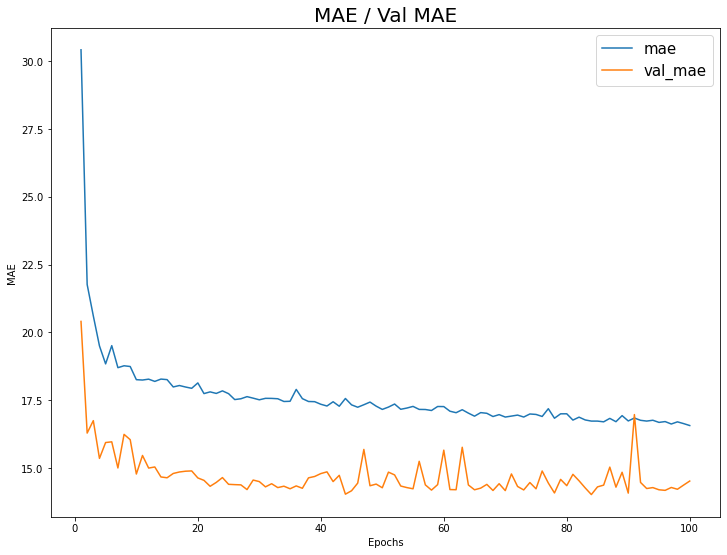

In [37]:
plt.figure(figsize=(12, 9))
plt.plot(np.arange(1, epochs+1), history.history['mae'])
plt.plot(np.arange(1, epochs+1), history.history['val_mae'])
plt.title('MAE / Val MAE', fontsize=20)
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend(['mae', 'val_mae'], fontsize=15)
plt.show()